In [1]:
import numpy as np
import glob
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt

/scratch/gpfs/WBIALEK/ls1546/.conda/envs/gpt-circuits/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def consolidate(fileformat):
    files = np.array(glob.glob(fileformat))
    numbers=[int(f.split("/")[-1].split(".")[0]) for f in files]
    files=files[np.argsort(numbers)]

    tensors=[]
    print(f"Loading {len(files)} files from {fileformat}")
    for fname in files:
        with open(fname,'rb') as f:
            tensors.append(np.load(f))
    
    return np.vstack(tensors)

def loaddata(loaddir):
    msk=consolidate(loaddir+'attn/*.npy')
    etens=consolidate(loaddir+'entropy/*.npy')
    ctens=consolidate(loaddir+'codelength/*.npy') 
    ttens=consolidate(loaddir+'tok/*.npy')

    return {'e': etens,
            'c': ctens,
            'm': msk,
            't': ttens,
            'dir': loaddir}

def takeaverage(data):

    nos=data['m'].sum(axis=0)
    weights=data['m']/data['m'].sum(axis=0,keepdims=True)
    eaverage=(data['e']*weights).sum(axis=0)
    caverage=(data['c']*weights[:,:-1]).sum(axis=0)

    return {'e': eaverage,
            'c': caverage,
            'n': nos}

def loaddataC(loaddir):
    msk=consolidate(loaddir+'attn/*.npy')
    etens=consolidate(loaddir+'entropy/*.npy')
    ctens=consolidate(loaddir+'codelength/*.npy') 
    ptens=consolidate(loaddir+'pleak/*.npy')
    ltens=consolidate(loaddir+'tlens/*.npy')
    ttens=consolidate(loaddir+'tok/*.npy')

    return {'e': etens,
            'c': ctens,
            'm': msk,
            'p': ptens,
            'l': ltens,
            't': ttens,
            'dir': loaddir}

def takeaverageC(data):
    positions=data['l'].cumsum(axis=-1)
    pflat = positions.flatten()
    msk = data['m'].flatten()
    gmask=np.ones_like(data['m'])
    gmask[:,-1]=0
    gmask=gmask.astype('bool').flatten()
    validpos, inv = np.unique(pflat, return_inverse=True)
    nsamples = np.bincount(inv, weights=msk)
    e_sum = np.bincount(inv, weights=data['e'].flatten() * msk)
    eaverage = np.divide(e_sum, nsamples, out=np.zeros_like(e_sum), where=nsamples>0)
    c_sum = np.bincount(inv[gmask], weights=data['c'].flatten() * msk[gmask],minlength=nsamples.shape[0])
    caverage = np.divide(c_sum, nsamples, out=np.zeros_like(c_sum), where=nsamples>0)
    
    averages={"n": nsamples,
              'c': caverage,
              'e': eaverage,
              'vp': validpos}
    return averages

In [5]:
# load the BBC data
data = loaddataC('/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/BBC/')

Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/BBC/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/BBC/entropy/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/BBC/codelength/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/BBC/pleak/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/BBC/tlens/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/BBC/tok/*.npy


In [6]:
avgs = takeaverageC(data)
avgs

{'n': array([514., 442., 481., ...,   1.,   2.,   1.], shape=(10226,)),
 'c': array([3.76373466, 3.02732324, 2.54039233, ..., 0.        , 0.11527214,
        0.        ], shape=(10226,)),
 'e': array([4.36181644, 4.04495093, 3.27003749, ..., 2.34623647, 1.62496448,
        0.98969322], shape=(10226,)),
 'vp': array([    1,     2,     3, ..., 10262, 10265, 10274], shape=(10226,))}

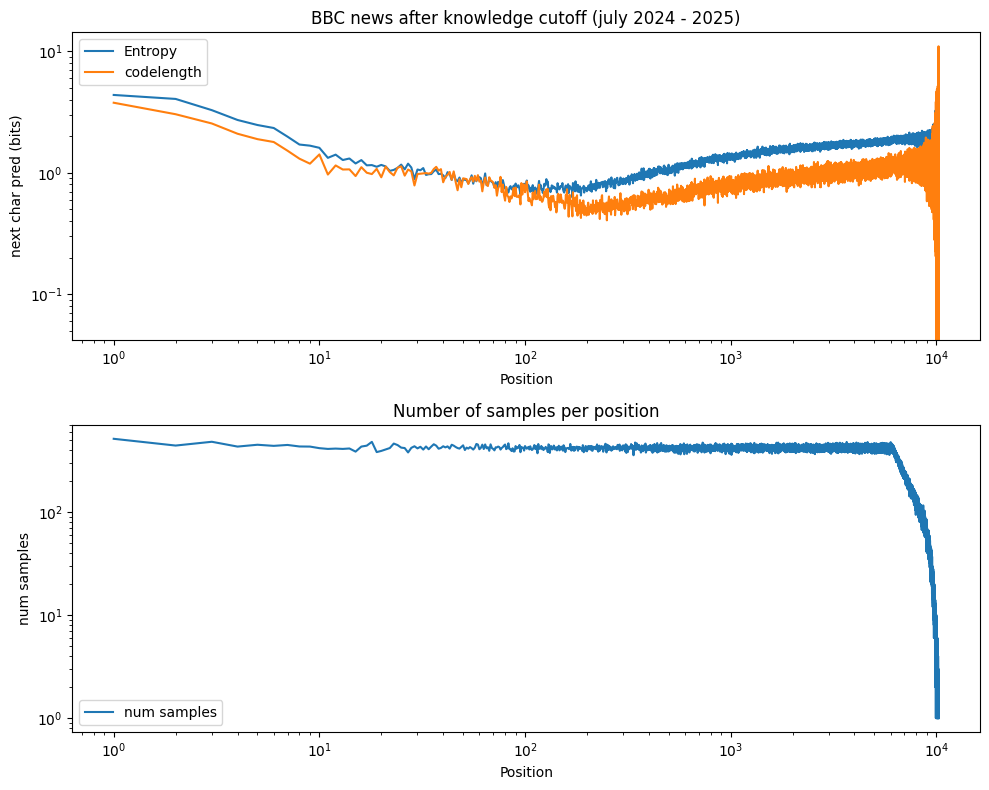

In [7]:
# plot the averages vs position
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(avgs['vp'], avgs['e'], label='Entropy')
axs[0].plot(avgs['vp'], avgs['c'], label='codelength')

axs[0].set_xlabel('Position')
axs[0].set_ylabel('next char pred (bits)')
axs[0].set_title('BBC news after knowledge cutoff (july 2024 - 2025)')
axs[0].legend()
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[1].plot(avgs['vp'], avgs['n'], label='num samples')
axs[1].set_xlabel('Position')
axs[1].set_ylabel('num samples')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title('Number of samples per position')
axs[1].legend()
plt.tight_layout()

In [10]:
# load the c4 data
datac4 = loaddataC('/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/c4/')
avgsc4 = takeaverageC(datac4)
avgsc4

Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/c4/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/c4/entropy/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/c4/codelength/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/c4/pleak/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/c4/tlens/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/c4/tok/*.npy


{'n': array([497., 501., 467., ...,   1.,   1.,   1.], shape=(12596,)),
 'c': array([3.79476664, 2.93861271, 2.31151111, ..., 0.47280627, 0.40426835,
        0.        ], shape=(12596,)),
 'e': array([4.18418433, 3.8844656 , 3.03820456, ..., 1.70681024, 1.46213913,
        1.80579317], shape=(12596,)),
 'vp': array([    1,     2,     3, ..., 13665, 13675, 13685], shape=(12596,))}

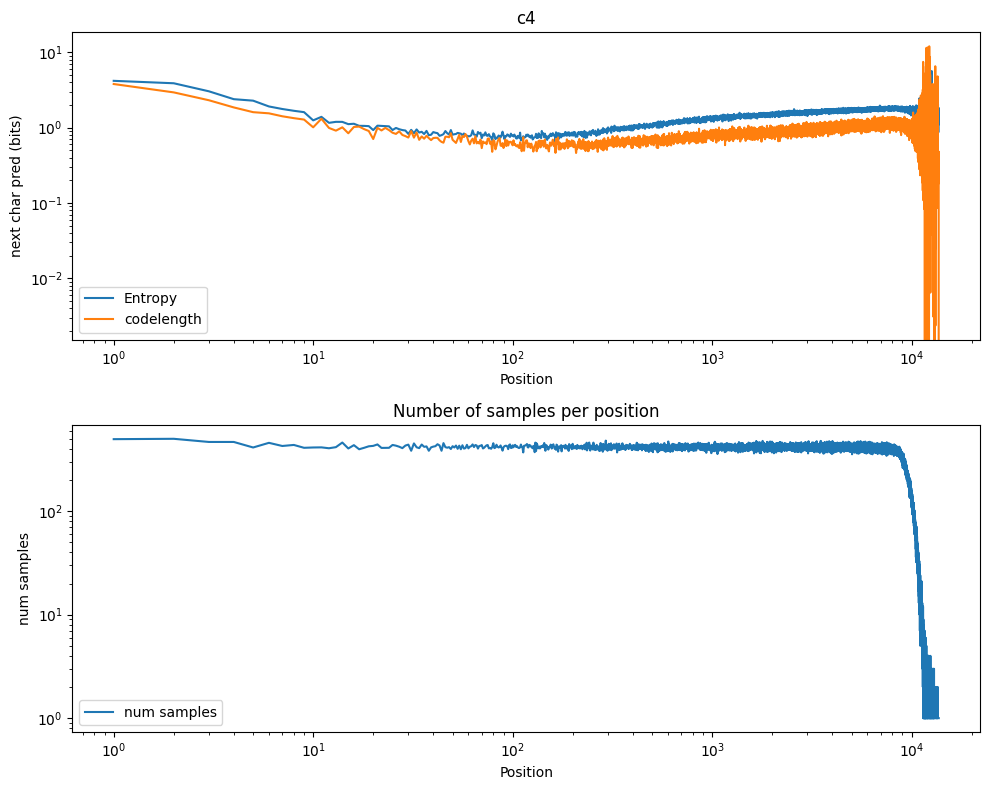

In [11]:
# plot the averages vs position
# # only plot positions < 5000
# reduced_pos = avgsc4['vp'] < 5000
# avgsc4 = {k: v[reduced_pos] for k, v in avgsc4.items()}
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(avgsc4['vp'], avgsc4['e'], label='Entropy')
axs[0].plot(avgsc4['vp'], avgsc4['c'], label='codelength')

axs[0].set_xlabel('Position')
axs[0].set_ylabel('next char pred (bits)')
axs[0].set_title('c4')
axs[0].legend()
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[1].plot(avgsc4['vp'], avgsc4['n'], label='num samples')
axs[1].set_xlabel('Position')
axs[1].set_ylabel('num samples')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title('Number of samples per position')
axs[1].legend()
plt.tight_layout()

In [12]:
# try with olmo to see if this is just model dependent or there is still an error in calc entropy/codelength
dataolmo = loaddataC('/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/BBC/')
avgsolmo = takeaverageC(dataolmo)
avgsolmo

Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/BBC/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/BBC/entropy/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/BBC/codelength/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/BBC/pleak/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/BBC/tlens/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/BBC/tok/*.npy


{'n': array([515., 478., 500., ...,   1.,   1.,   1.], shape=(10270,)),
 'c': array([2.95972418e+00, 2.61245762e+00, 2.07520682e+00, ...,
        2.78896827e-04, 1.03192090e-03, 0.00000000e+00], shape=(10270,)),
 'e': array([3.79073203e+00, 3.28705768e+00, 2.52577666e+00, ...,
        3.74934124e-03, 1.21177230e-02, 5.27567983e-01], shape=(10270,)),
 'vp': array([    1,     2,     3, ..., 10469, 10473, 10477], shape=(10270,))}

In [13]:
avgsolmo['e'][:1000]

array([3.79073203, 3.28705768, 2.52577666, 2.03242322, 1.82088435,
       1.70597805, 1.53021862, 1.42361793, 1.2594949 , 1.29501045,
       1.1092008 , 1.19754821, 1.13071721, 1.01523375, 1.0474703 ,
       1.05540804, 1.02672445, 0.92794692, 0.93588362, 0.97548977,
       0.91696295, 0.92872195, 0.91179645, 1.01270895, 1.01064636,
       0.89594905, 0.97718655, 0.9173793 , 0.74927314, 0.94311669,
       0.85163492, 0.92914686, 0.88677676, 0.82727859, 0.88204555,
       0.86750404, 0.89436663, 0.82236011, 0.89418335, 0.81267019,
       0.81229193, 0.89199327, 0.90050433, 0.72207604, 0.88156057,
       0.74092303, 0.73275828, 0.74545193, 0.74843198, 0.75290238,
       0.75073664, 0.7672697 , 0.69178548, 0.72817685, 0.77375508,
       0.70919905, 0.75412614, 0.66874044, 0.74114764, 0.83830118,
       0.72955088, 0.5949224 , 0.64103383, 0.8090307 , 0.64078407,
       0.63680459, 0.725176  , 0.70869339, 0.79008348, 0.66761538,
       0.59245537, 0.66441343, 0.64298612, 0.68462937, 0.62912

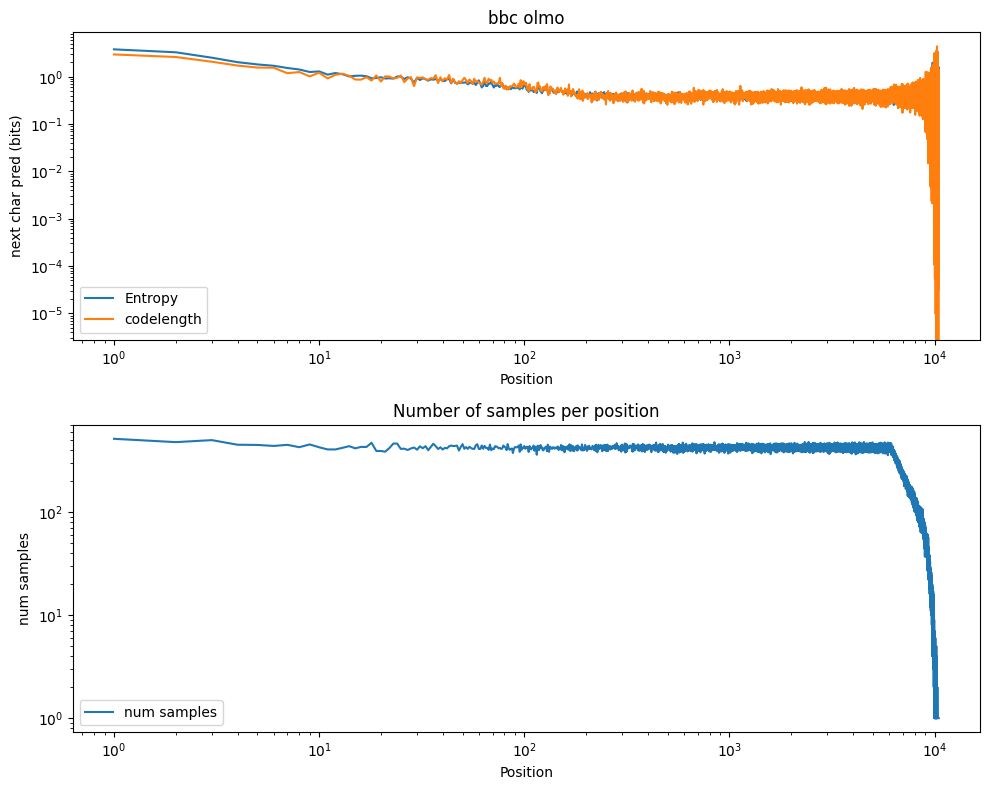

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(avgsolmo['vp'], avgsolmo['e'], label='Entropy')
axs[0].plot(avgsolmo['vp'], avgsolmo['c'], label='codelength')

axs[0].set_xlabel('Position')
axs[0].set_ylabel('next char pred (bits)')
axs[0].set_title('bbc olmo')
axs[0].legend()
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[1].plot(avgsolmo['vp'], avgsolmo['n'], label='num samples')
axs[1].set_xlabel('Position')
axs[1].set_ylabel('num samples')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title('Number of samples per position')
axs[1].legend()
plt.tight_layout()

In [15]:
# try with olmo to see if this is just model dependent or there is still an error in calc entropy/codelength
dataolmoc4 = loaddataC('/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/c4/')
avgsolmoc4 = takeaverageC(dataolmoc4)
avgsolmoc4

Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/c4/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/c4/entropy/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/c4/codelength/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/c4/pleak/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/c4/tlens/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/c4/tok/*.npy


{'n': array([529., 491., 482., ...,   1.,   1.,   1.], shape=(12296,)),
 'c': array([3.00412072, 2.58010341, 1.87492949, ..., 0.042541  , 0.02052796,
        0.        ], shape=(12296,)),
 'e': array([3.62561349, 3.14327064, 2.39117389, ..., 0.20745853, 0.13891584,
        0.03254789], shape=(12296,)),
 'vp': array([    1,     2,     3, ..., 13591, 13596, 13602], shape=(12296,))}

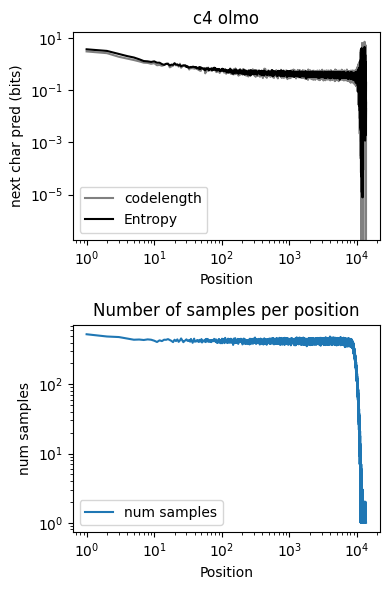

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(4, 6))
axs[0].plot(avgsolmoc4['vp'], avgsolmoc4['c'].squeeze(), label='codelength', color='gray')
axs[0].plot(avgsolmoc4['vp'], avgsolmoc4['e'], label='Entropy', color='black')

axs[0].set_xlabel('Position')
axs[0].set_ylabel('next char pred (bits)')
axs[0].set_title('c4 olmo')
axs[0].legend()
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[1].plot(avgsolmoc4['vp'], avgsolmoc4['n'], label='num samples')
axs[1].set_xlabel('Position')
axs[1].set_ylabel('num samples')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title('Number of samples per position')
axs[1].legend()
plt.tight_layout()

In [ ]:
d = """This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B.
This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B.
This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B.This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B. This is a test sentence to check the tokenizer and model outputs for GPT-OSS 20B."""

: 

In [5]:
# check if the tokenizer for gpt-oss produces different length tensors than olmo
shapecut = 2000
device = 'cuda'
model = AutoModelForCausalLM.from_pretrained("openai/gpt-oss-20b")
tokenizer = AutoTokenizer.from_pretrained("openai/gpt-oss-20b")

inputs = tokenizer(d, return_tensors='pt', return_token_type_ids=False, padding='max_length', max_length=shapecut,truncation=True).to(device) 
model.to(device) 
outputs=model(**inputs)

MXFP4 quantization requires Triton and kernels installed: CUDA requires Triton >= 3.4.0, XPU requires Triton >= 3.5.0, we will default to dequantizing the model to bf16
Loading checkpoint shards:   0%|                                                                             | 0/3 [00:00<?, ?it/s]

: 

: 

In [1]:
inputs['input_ids'].shape, inputs['attention_mask'].shape, outputs.logits.shape

NameError: name 'inputs' is not defined